<h1> Notebook showing the clustering of data id "IOOO" on 2020-01-01 </h1>

<h3> Documentation for hdbscan library in python: </h3>
<a> https://cran.r-project.org/web/packages/dbscan/vignettes/hdbscan.html </a>

In [101]:
# import libraries needed
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [102]:
# load data
user0_df = pd.read_csv("./CleanData/movements_0.csv")

print(user0_df)

          id   longitude   latitude        date      time
0       I000 -122.335167  47.608013  2020-01-01  00:00:00
1       I000 -122.335168  47.608002  2020-01-01  00:01:07
2       I000 -122.335169  47.608598  2020-01-01  00:02:30
3       I000 -122.335168  47.608501  2020-01-01  00:03:40
4       I000 -122.335169  47.607648  2020-01-01  00:05:07
...      ...         ...        ...         ...       ...
526483  I000 -122.426741  47.572358  2020-12-30  23:56:41
526484  I000 -122.426741  47.572356  2020-12-30  23:57:14
526485  I000 -122.426741  47.572213  2020-12-30  23:58:03
526486  I000 -122.316388  47.618509  2020-12-30  23:59:13
526487  I000 -122.316388  47.617609  2020-12-31  00:00:26

[526488 rows x 5 columns]


In [103]:
# let's start off with just the first day of data
first_day = user0_df[user0_df["date"]=="2020-01-01"]
print(first_day)

        id   longitude   latitude        date      time
0     I000 -122.335167  47.608013  2020-01-01  00:00:00
1     I000 -122.335168  47.608002  2020-01-01  00:01:07
2     I000 -122.335169  47.608598  2020-01-01  00:02:30
3     I000 -122.335168  47.608501  2020-01-01  00:03:40
4     I000 -122.335169  47.607648  2020-01-01  00:05:07
...    ...         ...        ...         ...       ...
1442  I000 -122.381754  47.543701  2020-01-01  23:55:41
1443  I000 -122.381754  47.543135  2020-01-01  23:56:38
1444  I000 -122.381754  47.543680  2020-01-01  23:57:26
1445  I000 -122.381754  47.543708  2020-01-01  23:58:39
1446  I000 -122.381755  47.543255  2020-01-01  23:59:29

[1447 rows x 5 columns]


<h2> How accurate does lat long need to be? Can we round? </h2>
<p> So, as you can see from the table below, a lat/long rounded up to a single decimal place can accurately identify a country or region, whereas rounded up to two could identify a large city or district. But five decimal places can accurately hone in on an individual tree, and six can identify a person. </p>
<a> https://blis.com/precision-matters-critical-importance-decimal-places-five-lowest-go/ </a>
<p> Therefore; we can round down to 4 if needed as it "Can identify an individual street or parcel of land" and has a distance of 11.1 meters. </p>

In [104]:
# round to 4 decimal places
rounded_df = first_day[["longitude", "latitude"]].round(4)
rounded_df[["id","date","time"]] = first_day[["id","date","time"]]
print(rounded_df)

      longitude  latitude    id        date      time
0     -122.3352   47.6080  I000  2020-01-01  00:00:00
1     -122.3352   47.6080  I000  2020-01-01  00:01:07
2     -122.3352   47.6086  I000  2020-01-01  00:02:30
3     -122.3352   47.6085  I000  2020-01-01  00:03:40
4     -122.3352   47.6076  I000  2020-01-01  00:05:07
...         ...       ...   ...         ...       ...
1442  -122.3818   47.5437  I000  2020-01-01  23:55:41
1443  -122.3818   47.5431  I000  2020-01-01  23:56:38
1444  -122.3818   47.5437  I000  2020-01-01  23:57:26
1445  -122.3818   47.5437  I000  2020-01-01  23:58:39
1446  -122.3818   47.5433  I000  2020-01-01  23:59:29

[1447 rows x 5 columns]


In [105]:
# group by (latitude,longitude) points to see most visited streets/parcels of land of about 11m in distance
groups = rounded_df.groupby(["longitude", "latitude"]).count().reset_index().sort_values("id")
print(groups[groups["id"]<=5])

     longitude  latitude  id  date  time
0    -122.4359   47.6175   1     1     1
289  -122.3179   47.5898   1     1     1
285  -122.3201   47.5662   1     1     1
283  -122.3201   47.5660   1     1     1
282  -122.3201   47.5659   1     1     1
..         ...       ...  ..   ...   ...
497  -122.2835   47.6630   5     5     5
462  -122.2994   47.5876   5     5     5
521  -122.2828   47.6440   5     5     5
475  -122.2835   47.6607   5     5     5
276  -122.3201   47.5651   5     5     5

[540 rows x 5 columns]


<p> 540 points that show up less than 6 times. </p>

In [106]:
# keep only the points with occurrence > 5
filtered_df = groups[groups["id"]>5]
print(filtered_df)

     longitude  latitude  id  date  time
401  -122.3068   47.5712   6     6     6
272  -122.3201   47.5647   6     6     6
327  -122.3164   47.6142   6     6     6
436  -122.3028   47.6034   6     6     6
522  -122.2828   47.6441   6     6     6
274  -122.3201   47.5649   6     6     6
476  -122.2835   47.6608   6     6     6
266  -122.3201   47.5641   6     6     6
268  -122.3201   47.5643   6     6     6
562  -122.2725   47.6494   6     6     6
311  -122.3164   47.6120   6     6     6
230  -122.3270   47.5441   6     6     6
233  -122.3270   47.5444   6     6     6
451  -122.2994   47.5859   6     6     6
357  -122.3164   47.6190   6     6     6
186  -122.3352   47.6067   6     6     6
267  -122.3201   47.5642   6     6     6
399  -122.3068   47.5710   6     6     6
255  -122.3201   47.5630   6     6     6
373  -122.3107   47.6244   6     6     6
457  -122.2994   47.5866   6     6     6
372  -122.3107   47.6243   6     6     6
208  -122.3335   47.6706   6     6     6
329  -122.3164  

In [107]:
# merge filtered with rounded
merged1 = pd.merge(rounded_df, filtered_df, on=["latitude","longitude"])
merged1 = merged1.drop(["id_x", "id_y","date_y", "time_y", "longitude", "latitude"], axis=1)
print(merged1)

         date_x    time_x
0    2020-01-01  00:15:18
1    2020-01-01  00:15:55
2    2020-01-01  00:18:22
3    2020-01-01  00:18:59
4    2020-01-01  00:20:52
..          ...       ...
294  2020-01-01  22:22:42
295  2020-01-01  22:30:13
296  2020-01-01  22:33:17
297  2020-01-01  22:35:45
298  2020-01-01  22:48:10

[299 rows x 2 columns]


In [108]:
# merge first day with filtered to keep only the points with occurrence > 5
merged2 = pd.merge(first_day, merged1, left_on=["date","time"], right_on=["date_x","time_x"])
merged2 = merged2.drop(["date_x", "time_x"], axis=1)
print(merged2)

       id   longitude   latitude        date      time
0    I000 -122.335171  47.606657  2020-01-01  00:15:18
1    I000 -122.335170  47.606670  2020-01-01  00:15:55
2    I000 -122.335170  47.606690  2020-01-01  00:18:22
3    I000 -122.335170  47.606689  2020-01-01  00:18:59
4    I000 -122.335170  47.606662  2020-01-01  00:20:52
..    ...         ...        ...         ...       ...
294  I000 -122.333503  47.670419  2020-01-01  23:16:22
295  I000 -122.333503  47.670392  2020-01-01  23:17:02
296  I000 -122.333503  47.670391  2020-01-01  23:17:45
297  I000 -122.333502  47.670631  2020-01-01  23:25:42
298  I000 -122.333502  47.670628  2020-01-01  23:30:10

[299 rows x 5 columns]


In [109]:
print(merged2[["longitude", "latitude"]])

      longitude   latitude
0   -122.335171  47.606657
1   -122.335170  47.606670
2   -122.335170  47.606690
3   -122.335170  47.606689
4   -122.335170  47.606662
..          ...        ...
294 -122.333503  47.670419
295 -122.333503  47.670392
296 -122.333503  47.670391
297 -122.333502  47.670631
298 -122.333502  47.670628

[299 rows x 2 columns]


In [110]:
scaler = StandardScaler()
points = merged2[["longitude", "latitude"]]
scaled_df = scaler.fit_transform(points)

# create clusterer
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
# labels assigns each point to a cluster
labels = clusterer.fit_predict(scaled_df)

# add the clusters to the df
merged2['cluster'] = labels

print(merged2)

       id   longitude   latitude        date      time  cluster
0    I000 -122.335171  47.606657  2020-01-01  00:15:18       -1
1    I000 -122.335170  47.606670  2020-01-01  00:15:55       -1
2    I000 -122.335170  47.606690  2020-01-01  00:18:22       -1
3    I000 -122.335170  47.606689  2020-01-01  00:18:59       -1
4    I000 -122.335170  47.606662  2020-01-01  00:20:52       -1
..    ...         ...        ...         ...       ...      ...
294  I000 -122.333503  47.670419  2020-01-01  23:16:22       -1
295  I000 -122.333503  47.670392  2020-01-01  23:17:02       -1
296  I000 -122.333503  47.670391  2020-01-01  23:17:45       -1
297  I000 -122.333502  47.670631  2020-01-01  23:25:42       -1
298  I000 -122.333502  47.670628  2020-01-01  23:30:10       -1

[299 rows x 6 columns]


In [111]:
# see how many points are per cluster
print(merged2.groupby("cluster").count().reset_index())

   cluster  id  longitude  latitude  date  time
0       -1  32         32        32    32    32
1        0  25         25        25    25    25
2        1  42         42        42    42    42
3        2  19         19        19    19    19
4        3  51         51        51    51    51
5        4  59         59        59    59    59
6        5  45         45        45    45    45
7        6  26         26        26    26    26


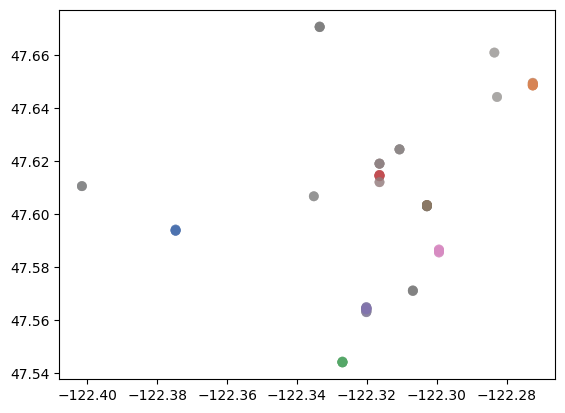

In [113]:
# visualize clusters
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in labels]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(points["longitude"], points["latitude"], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)